Predict whether a bank customer will subscribe to a term deposit as a result of a marketing
campaign.

In [ ]:
#INSTALLED REQUIRED PACKAGES 
!pip install pandas numpy scikit-learn matplotlib shap joblib
# If you don't want SHAP explanation now, omit shap from install


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# IMPORT LIBRARIES 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score, roc_auc_score,
    roc_curve, ConfusionMatrixDisplay, precision_recall_curve
)
from sklearn.inspection import permutation_importance

import joblib
import random
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)






In [ ]:
#LOAD THE CSV AND QUICK CHECKS
import pandas as pd

path = r"C:\Users\SR Laptop\Desktop\Task-1\bank-additional-full.csv"
df = pd.read_csv(path, sep=';')

# Create numeric binary target
df['subscribed'] = (df['y'] == 'yes').astype(int)

print("Shape:", df.shape)
print("\nTarget counts:")
print(df['subscribed'].value_counts())
display(df.head())



Shape: (41188, 22)

Target counts:
subscribed
0    36548
1     4640
Name: count, dtype: int64


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,subscribed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0


In [ ]:
#CHOOSE WHETHER TO DROP DURATION(RECOMMENDED FOR PRECALL MODEL)
df = df.drop(columns=['duration']) # If you want a model usable BEFORE the call, uncomment the next line
# If you want to include duration (not recommended for pre-call), leave it.


In [ ]:
#PREPARE FEATURES(QUICK&SIMPLE-GET DUMMIES)
X = df.drop(columns=['y', 'subscribed']) # Drop the original 'y' and keep the new binary 'subscribed'
X = pd.get_dummies(X, drop_first=True)   # quick one-line encoding
y = df['subscribed']

print("Feature matrix shape:", X.shape)


Feature matrix shape: (41188, 52)


In [ ]:
#TRAIN /TEST SPLIT 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (30891, 52) Test: (10297, 52)


In [ ]:
#TRAIN LOGISTIC REGRESSION AND RANDOM FOREST
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

lr = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)


C:\Users\SR Laptop\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


---- Logistic Regression ----
Confusion matrix:
 [[7827 1310]
 [ 412  748]]
              precision    recall  f1-score   support

           0     0.9500    0.8566    0.9009      9137
           1     0.3635    0.6448    0.4649      1160

    accuracy                         0.8328     10297
   macro avg     0.6567    0.7507    0.6829     10297
weighted avg     0.8839    0.8328    0.8518     10297

F1: 0.4648850217526414
ROC AUC: 0.8032913259086775
---- Random Forest ----
Confusion matrix:
 [[8887  250]
 [ 831  329]]
              precision    recall  f1-score   support

           0     0.9145    0.9726    0.9427      9137
           1     0.5682    0.2836    0.3784      1160

    accuracy                         0.8950     10297
   macro avg     0.7414    0.6281    0.6605     10297
weighted avg     0.8755    0.8950    0.8791     10297

F1: 0.3783783783783784
ROC AUC: 0.7814760371811468


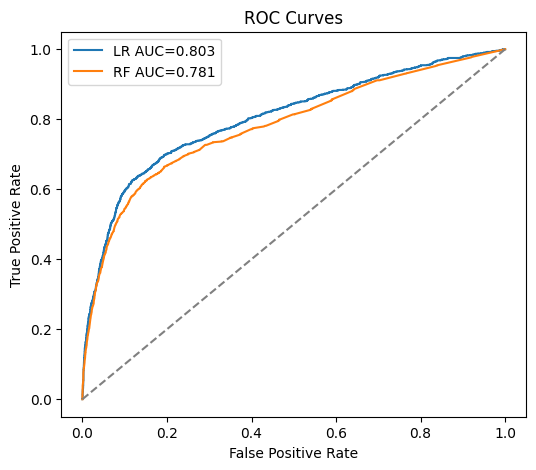

In [ ]:
#EVALUATE (CONFUSION MATRIX,F1, ROC AUC + ROC PLOT)
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt

def evaluate(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print("----", name, "----")
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))
    print("F1:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    return fpr, tpr

fpr_lr, tpr_lr = evaluate(lr, X_test, y_test, "Logistic Regression")
fpr_rf, tpr_rf = evaluate(rf, X_test, y_test, "Random Forest")

plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, label=f'LR AUC={roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]):.3f}')
plt.plot(fpr_rf, tpr_rf, label=f'RF AUC={roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]):.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()



In [ ]:
# GLOBAL FEATURE IMPORTANCE (PERMUTATION IMPORTANCE)
from sklearn.inspection import permutation_importance
import numpy as np

r = permutation_importance(rf, X_test, y_test, n_repeats=15, random_state=42, n_jobs=-1)
imp_idx = np.argsort(r.importances_mean)[::-1]
features = X_test.columns

print("Top 20 features by permutation importance:")
for i in imp_idx[:20]:
    print(f"{features[i]}: mean_imp={r.importances_mean[i]:.6f} std={r.importances_std[i]:.6f}")


Top 20 features by permutation importance:
pdays: mean_imp=0.004526 std=0.000447
poutcome_success: mean_imp=0.001275 std=0.000307
nr.employed: mean_imp=0.000829 std=0.000469
month_oct: mean_imp=0.000382 std=0.000130
housing_unknown: mean_imp=0.000155 std=0.000136
previous: mean_imp=0.000104 std=0.000598
loan_unknown: mean_imp=0.000071 std=0.000156
job_self-employed: mean_imp=0.000045 std=0.000245
job_housemaid: mean_imp=0.000045 std=0.000137
job_management: mean_imp=0.000000 std=0.000275
marital_unknown: mean_imp=0.000000 std=0.000035
default_yes: mean_imp=0.000000 std=0.000000
education_illiterate: mean_imp=0.000000 std=0.000000
housing_yes: mean_imp=-0.000078 std=0.000398
month_nov: mean_imp=-0.000091 std=0.000214
job_unknown: mean_imp=-0.000097 std=0.000123
poutcome_nonexistent: mean_imp=-0.000117 std=0.000521
job_student: mean_imp=-0.000129 std=0.000116
euribor3m: mean_imp=-0.000149 std=0.000581
month_sep: mean_imp=-0.000188 std=0.000083


In [28]:
import numpy as np
import shap

explainer = shap.TreeExplainer(rf)   # your RF model

# sample
np.random.seed(42)
sample_positions = np.random.choice(X_test.shape[0], size=5, replace=False)
X_test_sample = X_test.iloc[sample_positions]

# compute shap values (could be list or array depending on shap version)
shap_out = explainer.shap_values(X_test_sample)
print("type(shap_out):", type(shap_out))

# If shap_out is a list (multi-class / classifier), take class-1 (positive)
if isinstance(shap_out, list):
    print("shap_out is a list with lengths:", [arr.shape for arr in shap_out])
    shap_pos = shap_out[1]    # usually positive-class
else:
    print("shap_out shape:", getattr(shap_out, "shape", "no shape"))
    shap_pos = shap_out

print("X_test_sample shape:", X_test_sample.shape)
print("shap_pos shape:", getattr(shap_pos, "shape", "no shape"))

# Compare feature counts
print("n_features in X_test_sample:", X_test_sample.shape[1])
if hasattr(shap_pos, "shape"):
    print("n_features in shap_pos vectors:", shap_pos.shape[1])
else:
    print("shap_pos has no shape attribute")



type(shap_out): <class 'numpy.ndarray'>
shap_out shape: (5, 52, 2)
X_test_sample shape: (5, 52)
shap_pos shape: (5, 52, 2)
n_features in X_test_sample: 52
n_features in shap_pos vectors: 52


In [ ]:
# EXPLAIN 5 PREDICTIONS WITH SHAP
import numpy as np
import pandas as pd
import shap

explainer = shap.TreeExplainer(rf)  # your trained RandomForest

# sample 5 random test rows (relative positions)
np.random.seed(42)
sample_positions = np.random.choice(X_test.shape[0], size=5, replace=False)
X_test_sample = X_test.iloc[sample_positions]

# compute SHAP output
shap_out = explainer.shap_values(X_test_sample)
print("raw shap_out type:", type(shap_out), "shape (if ndarray):", getattr(shap_out, "shape", None))

if isinstance(shap_out, np.ndarray):
    # pick positive class (class index 1)
    # result shape -> (n_samples, n_features)
    shap_pos = shap_out[:, :, 1]
elif isinstance(shap_out, list):
    # older shap returns list per class; shap_out[1] is (n_samples, n_features)
    shap_pos = shap_out[1]
else:
    # shap.Explanation object
    vals = shap_out.values
    if vals.ndim == 3:          # (n_samples, n_features, n_classes) OR (n_classes, n_samples, n_features)
        # try to infer layout
        if vals.shape[0] == X_test_sample.shape[0]:
            # likely (n_samples, n_features, n_classes)
            shap_pos = vals[:, :, 1]
        else:
            # likely (n_classes, n_samples, n_features)
            shap_pos = vals[1, :, :]
    else:
        shap_pos = vals

# final sanity check
assert shap_pos.shape[0] == X_test_sample.shape[0] and shap_pos.shape[1] == X_test_sample.shape[1], \
    f"SHAP shape mismatch: {shap_pos.shape} vs {X_test_sample.shape}"

# Print top 8 contributors for each sample
for i in range(shap_pos.shape[0]):
    row_index = sample_positions[i]           # original X_test index
    true_label = y_test.reset_index(drop=True).loc[row_index]
    sv = shap_pos[i]                          # vector length == n_features
    feature_names = X_test_sample.columns
    df_sh = pd.DataFrame({'feature': feature_names, 'shap_value': sv})
    df_sh['abs'] = df_sh['shap_value'].abs()
    df_sh = df_sh.sort_values('abs', ascending=False).head(8).drop(columns='abs')
    print(f"\nExample {i+1} (test-index {row_index}) true label = {true_label}")
    print(df_sh.to_string(index=False))






raw shap_out type: <class 'numpy.ndarray'> shape (if ndarray): (5, 52, 2)

Example 1 (test-index 5317) true label = 0
          feature  shap_value
contact_telephone   -0.025402
     emp.var.rate   -0.025085
      nr.employed   -0.011201
   cons.price.idx   -0.008522
              age   -0.008425
  day_of_week_mon   -0.006243
            pdays   -0.004926
         campaign    0.003869

Example 2 (test-index 3688) true label = 0
                    feature  shap_value
          contact_telephone   -0.024708
               emp.var.rate   -0.018089
                nr.employed   -0.010395
                  month_may   -0.009174
             marital_single   -0.008121
             cons.price.idx   -0.006233
            day_of_week_mon   -0.006154
education_university.degree    0.005721

Example 3 (test-index 8771) true label = 1
              feature  shap_value
                pdays    0.138545
            euribor3m    0.069553
     poutcome_success    0.065484
          nr.employed    0.0

In [ ]:
# SAVE THE TRAINED RANDOMFOREST PIPELINE
import joblib
joblib.dump(rf, "rf_bank_model.joblib")
joblib.dump(lr, "lr_bank_model.joblib")
# reload with joblib.load("rf_bank_model.joblib")


['lr_bank_model.joblib']

In [ ]:
# HELPFUL TINY UTILITIES 
orig_test_idx = X_test.index[2]   # index in original df
print("Original row from df:")
display(df.loc[orig_test_idx])


Original row from df:


age                        56
job                    admin.
marital               married
education            basic.9y
default                    no
housing                    no
loan                       no
contact              cellular
month                     oct
day_of_week               wed
campaign                    2
pdays                     999
previous                    0
poutcome          nonexistent
emp.var.rate             -3.4
cons.price.idx         92.431
cons.conf.idx           -26.9
euribor3m               0.742
nr.employed            5017.5
y                          no
subscribed                  0
Name: 38292, dtype: object